In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib.pyplot import subplots, style, rc, rc_context
from tqdm import tqdm
from venn import venn, pseudovenn
from collections import defaultdict
from itertools import count, islice
from functools import lru_cache
from argparse import Namespace

In [2]:
from glob import glob
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.metrics import silhouette_score
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [3]:
from scipy.cluster.hierarchy import cophenet
from scipy.stats import pearsonr, wilcoxon

In [4]:
from edgecaselib.formats import load_index, load_kmerscan
from edgecaselib.densityplot import interpret_arguments
from edgecaselib.util import natsorted_chromosomes
from pickle import dump, load
from os import path
from tempfile import NamedTemporaryFile
from subprocess import check_output, CalledProcessError
from pysam import AlignmentFile
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from scipy.ndimage import uniform_filter1d
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.lines import Line2D

In [5]:
def wilcoxon_dropna(df, a, b, alternative="less"):
    dfnona = df.dropna()
    try:
        return wilcoxon(dfnona[a], dfnona[b], alternative=alternative)
    except ValueError:
        return np.nan, np.nan

In [6]:
SAMFILTERS = ["is_q|tract_anchor", 3844, 0]
ecx = load_index("assets/hg38ext.fa.ecx")

In [7]:
SUBJECT_TO_TRIO = {
    "HG001": "NA12878",
    "HG002": "AshkenazimTrio", "HG003": "AshkenazimTrio", "HG004": "AshkenazimTrio",
    "HG005": "ChineseTrio", "HG006": "ChineseTrio", "HG007": "ChineseTrio",
}

In [8]:
RAW_GLOBAL_LDS = {
    re.sub(r'-matrix\.tsv$', "", filename.split("/")[-1]): pd.read_csv(filename, sep="\t", index_col=0)
    for filename in glob("PacBio/haplotypes/levenshtein-q_arm/*-matrix.tsv")
}

In [9]:
KMERSCANNER_PKL = "PacBio/kmerscanner-q_arm.pkl"
KMERSCANNER_DAT = "PacBio/kmerscanner-q_arm.dat.gz"

if path.isfile(KMERSCANNER_PKL):
    with open(KMERSCANNER_PKL, mode="rb") as pkl:
        DENSITIES = load(pkl)
else:
    DENSITIES = load_kmerscan(KMERSCANNER_DAT, True, SAMFILTERS, 10)
    with open(KMERSCANNER_PKL, mode="wb") as pkl:
        dump(DENSITIES, pkl)

In [10]:
MAXLEN = 1700

In [11]:
class GridFig():

    def __init__(self, width_ratios, height_ratios, scale=1):
        self.figure, _ = subplots(
            figsize=(sum(width_ratios)*scale, sum(height_ratios)*scale),
            ncols=0, nrows=0,
        )
        self.gs = GridSpec(
            ncols=len(width_ratios), wspace=0, width_ratios=width_ratios, 
            nrows=len(height_ratios), hspace=0, height_ratios=height_ratios,
            figure=self.figure,
        )
 
    def subplot(self, gridspec_slice, aspect="auto", frame=False):
        ax = self.figure.add_subplot(gridspec_slice, aspect=aspect)
        if frame is False:
            ax.set(frame_on=False)
        else:
            for spine in {"top", "right", "bottom", "left"} - set(frame):
                ax.spines[spine].set_visible(False)
        return ax

In [12]:
def plot_dendrogram(Z, gf):
    ax = gf.subplot(gf.gs[0,0])
    with rc_context({"lines.linewidth": .5}):
        dendrogram(
            Z, orientation="left",
            link_color_func=lambda x: "black", ax=ax,
        )
    ax.set(
        xticks=[], xlabel=None,
        yticks=[], ylabel=None,
        ylim=ax.get_ylim()[::-1],
    )

In [13]:
def plot_heatmap(data2d, gf, cmap="gray_r", vmax=.15):
    ax = gf.subplot(gf.gs[0,1])
    sns.heatmap(data2d, cmap=cmap, cbar=False, vmin=0, vmax=vmax, ax=ax)
    ax.set(xticks=[], yticks=[], xlabel=None, ylabel=None)

In [14]:
def cluster(lds, metric="correlation", method="ward"):
    Z = linkage(squareform(lds), metric=metric, method=method, optimal_ordering=True)
    leaves = dendrogram(Z, no_plot=True)["leaves"]
    data2d = lds.iloc[leaves, leaves].copy()
    dispatcher = pd.DataFrame(index=data2d.index)
    dispatcher.index.name = "read"
    to_subject = dispatcher.index.map(lambda s: s.split(":")[1])
    for subject in sorted(to_subject.drop_duplicates()):
        dispatcher[subject] = (to_subject==subject)
    return Z, data2d, dispatcher

In [15]:
def get_plottable_density_section(densities, chrom, motif, data2d, ecx):
    chrom_densities = densities[chrom]
    if motif is None:
        by_motif = chrom_densities[chrom_densities["motif"]=="TTAGGG"]
    else:
        by_motif = chrom_densities[chrom_densities["motif"]==motif]
    section = by_motif.set_index("name").reindex(data2d.index).iloc[:,8:].copy()
    if motif is None:
        section = (~section.isnull()).astype(int) / 3
    section.columns = section.columns.astype(int)
    anchor = ecx.loc[
        (ecx["rname"]==chrom) & (ecx["flag"]==0x4000) & (ecx["prime"]==3),
        "pos",
    ].iloc[0]
    return section[[c for c in section.columns if c>=anchor]]

In [16]:
def get_absentees(lds, densities, chrom, ecx):
    raw_section = get_plottable_density_section(densities, chrom, "TTAGGG", lds, ecx)
    nulls = raw_section.isnull().all(axis=1)
    return nulls[nulls].index

In [17]:
def section_to_RGB(ps, color, alpha_factor=1.2):
    return np.transpose(
        np.array([
            np.full_like(ps, color[0]),
            np.full_like(ps, color[1]),
            np.full_like(ps, color[2]),
            np.clip(ps*alpha_factor, a_min=None, a_max=1),
        ]),
        axes=(1, 2, 0),
    )

In [18]:
def draw_fancy_arrow(
    y, start, end, ax, lw=.25,
    csty="angle3,angleA=45,angleB=-45",
    asty="Simple, tail_width=.25, head_width=2, head_length=3"
):
    ax.add_patch(FancyArrowPatch(
        (start, y), (end, y),
        connectionstyle=csty,
        arrowstyle=asty,
        lw=lw, color="#888", clip_on=False,
    ))

In [19]:
POPULATION_COLORS = {
    "HG001": "black",
    "HG002": "green", "HG003": "green", "HG004": "green",
    "HG005": "steelblue", "HG006": "steelblue", "HG007": "steelblue",
}

def plot_subjects(dispatcher, gf, s=10):
    for i, subject in enumerate(sorted(SUBJECT_TO_TRIO)):
        sax = gf.subplot(gf.gs[0,i+3])
        sax.plot([0, 0], [0, len(dispatcher)], lw=.5, color="#888")
        if subject in dispatcher:
            truthiness = dispatcher[subject].reset_index(drop=True)
            positions = truthiness[truthiness].index
            for x in [-.1, 0, .1]:
                sax.scatter(x=[x]*len(positions), y=positions, marker="_", s=s, color=POPULATION_COLORS[subject])
        sax.set(
            xticks=[0], xticklabels=[subject+" "],
            yticks=[], xlabel=None, ylabel=None,
            xlim=(-.5, .5),
            ylim=(len(dispatcher), -1),
        )
        for tick in sax.get_xticklabels():
            tick.set_rotation(90)
        if subject in {"HG002", "HG005"}:
            draw_fancy_arrow(len(dispatcher), 1, 0, sax)
            draw_fancy_arrow(len(dispatcher), 2, 0, sax)
        sax.tick_params(axis="both", which="both", length=0)

In [20]:
IMSHOW_PALETTE = {
    None: [.7, .7, .7],
    "TTAGGG": [.1, .5, .2],
    "TGAGGG": [1, 1, 0],
    "TTGGGG": [.6, .27, .5],
    "TTAGGGG": [.5, .9, 1],
}

def plot_densities(densities, chrom, data2d, ecx, gf, extent, bin_size=100):
    ax = gf.subplot(gf.gs[0,-1])
    for motif, color in IMSHOW_PALETTE.items():
        ps = get_plottable_density_section(densities, chrom, motif, data2d, ecx).values
        breakat = ps.shape[1]//100
        if ps.shape[1] < MAXLEN:
            ps = np.pad(ps, ((0, 0), (0, MAXLEN-ps.shape[1])))
        pa = section_to_RGB(np.clip(uniform_filter1d(ps, 5, 1), a_min=0.0, a_max=1.0), color, 1.5)
        ax.imshow(pa, extent=extent, interpolation="nearest")
    ticklabels=np.linspace(0, MAXLEN//100, MAXLEN//100+1).astype(int).astype(str)
    ticklabels[breakat+1:] = ""
    xmin, xmax = extent[:2]
    ax.set(
        xticks=np.linspace(xmin, xmax, MAXLEN//100+1),
        xticklabels=ticklabels,
        xlabel="Kbp of telomeric tract",
        yticks=[], ylabel=None,
    )
    ax.tick_params(axis="both", which="both", length=0)
    ax.axhline(0, 0, (breakat+1)/len(ticklabels), lw=.5, c="black")

In [21]:
@lru_cache(maxsize=None)
def convname(cn):
    match = re.search(r'^\d+', cn)
    if match:
        return "chr" + match.group()
    else:
        return cn

In [22]:
def process_lds(raw_global_lds, chrom, densities, ecx):
    lds = raw_global_lds[chrom].copy()
    absentees = get_absentees(lds, densities, chrom, ecx)
    lds.drop(index=absentees, columns=absentees, inplace=True)
    Z, data2d, dispatcher = cluster(lds, metric="euclidean", method="ward")
    h = 6*len(lds)/200
    w = 30
    gf = GridFig([h/3,h,.3]+[.5]*7+[w], [h], scale=.4)
    plot_dendrogram(Z, gf=gf)
    plot_heatmap(data2d, gf=gf)
    plot_subjects(dispatcher, gf=gf, s=7)
    plot_densities(densities, chrom, data2d, ecx, gf=gf, extent=[0,w,0,h])
    if chrom != convname(chrom):
        name = "{} ({})".format(convname(chrom), chrom)
    else:
        name = chrom
    gf.figure.get_axes()[0].set_ylabel(name, fontsize=15)
    return lds, Z, data2d, dispatcher, gf

In [23]:
def cophenetic_correlation(lds, Z):
    r, p = pearsonr(squareform(lds), cophenet(Z))
    return r, max(p, 5e-324) # p-value of zero is just a rounding issue

In [24]:
def fixup_labels(gf, chrom):
    if chrom == "5qtel_1-500K_1_12_12_rc":
        gf.figure.get_axes()[1].set_title("Pairwise relative Levenshtein distances", fontsize=15)
        gf.figure.get_axes()[5].set_title("Subjects", fontsize=15)
        gf.figure.get_axes()[-1].set_title("   Motif densities", loc="left", fontsize=15)
    if chrom != "chrX":
        for ax in gf.figure.get_axes()[:-1]:
            ax.set(xticklabels=[], xlabel=None)
        gf.figure.get_axes()[-1].set(xlabel=None)
    if chrom == "16qtel_1-500K_1_12_12_rc":
        gf.figure.get_axes()[0].set_ylabel("chr16 (...)", fontsize=15)
    if chrom == "14qtel_1-500K_1_12_12_rc":
        gf.figure.get_axes()[0].set_ylabel("chr14 (14q...)", fontsize=15)

In [25]:
read_to_category = lambda dispatcher, pos: pd.Series(
    index=dispatcher.index,
    data=dispatcher.index.map(lambda s: s.split(":")[pos])
)

In [26]:
def count_subtrees(dispatcher):
    read_to_trio = read_to_category(dispatcher, 0)
    running_trio = None
    trio_runs = defaultdict(int)
    run = 0
    for trio in read_to_trio:
        if trio != running_trio:
            if run:
                trio_runs[running_trio] += 1
            running_trio, run = trio, 1
        else:
            run += 1
    if run:
        trio_runs[running_trio] += 1
    return trio_runs

In [27]:
reindex_to = lambda row, rtc, cat: row.reindex(rtc[rtc==cat].index).dropna()
reindex_in = lambda row, rtc: row.reindex(rtc[rtc==rtc[row.name]].index).dropna()
reindex_out = lambda row, rtc: row.reindex(rtc[rtc!=rtc[row.name]].index).dropna()

In [28]:
def get_closest_distances(lds, dispatcher):
    read_to_trio = read_to_category(dispatcher, 0)
    read_to_subject = read_to_category(dispatcher, 1)
    return lds.apply(
        lambda row: pd.Series({
            "subject": reindex_in(row, read_to_subject).drop(index=row.name).min(),
            "trio": reindex_in(reindex_out(row, read_to_subject), read_to_trio).min(),
            "outgroup": reindex_out(row, read_to_trio).min(),
        }),
        axis=1,
    )

In [29]:
def subject_to_subject_lds(lds, dispatcher, a, b):
    read_to_subject = read_to_category(dispatcher, 1)
    return lds.loc[read_to_subject[read_to_subject==a].index, read_to_subject[read_to_subject==b].index]

In [30]:
def get_closest_family_distances(lds, dispatcher, **kwargs):
    target, test, control = list(kwargs)
    return pd.DataFrame({
        f"{test} to {target}": subject_to_subject_lds(lds, dispatcher, kwargs[test], kwargs[target]).min(axis=1),
        f"{test} to {control}": subject_to_subject_lds(lds, dispatcher, kwargs[test], kwargs[control]).min(axis=1),
    })

In [31]:
def process_distances(lds, dispatcher):
    closest_distances = get_closest_distances(lds, dispatcher)
    ashkenazim_from_father = get_closest_family_distances(lds, dispatcher, son="HG002", father="HG003", mother="HG004")
    ashkenazim_from_mother = get_closest_family_distances(lds, dispatcher, son="HG002", mother="HG004", father="HG003")
    chinese_from_father = get_closest_family_distances(lds, dispatcher, son="HG005", father="HG006", mother="HG007")
    chinese_from_mother = get_closest_family_distances(lds, dispatcher, son="HG005", mother="HG007", father="HG006")
    return (
        closest_distances,
        ashkenazim_from_father, ashkenazim_from_mother,
        chinese_from_father, chinese_from_mother,
        wilcoxon_dropna(closest_distances, "subject", "trio")[1],
        wilcoxon_dropna(closest_distances, "subject", "outgroup")[1],
        wilcoxon_dropna(closest_distances, "trio", "outgroup")[1],
        wilcoxon_dropna(ashkenazim_from_father, "father to son", "father to mother")[1],
        wilcoxon_dropna(ashkenazim_from_mother, "mother to son", "mother to father")[1],
        wilcoxon_dropna(chinese_from_father, "father to son", "father to mother")[1],
        wilcoxon_dropna(chinese_from_mother, "mother to son", "mother to father")[1],
    )

  0%|          | 0/18 [00:00<?, ?it/s]/home/kirill/usr/opt/miniconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
 11%|█         | 2/18 [00:01<00:14,  1.08it/s]/home/kirill/usr/opt/miniconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
 83%|████████▎ | 15/18 [02:45<00:33, 11.05s/it]/home/kirill/usr/opt/miniconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
100%|██████████| 18/18 [02:59<00:00,  9.96s/it]


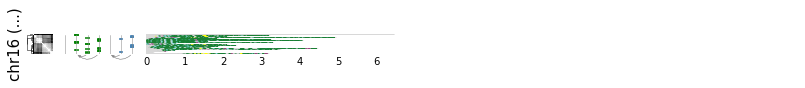

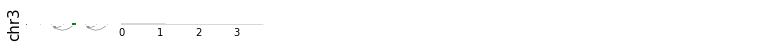

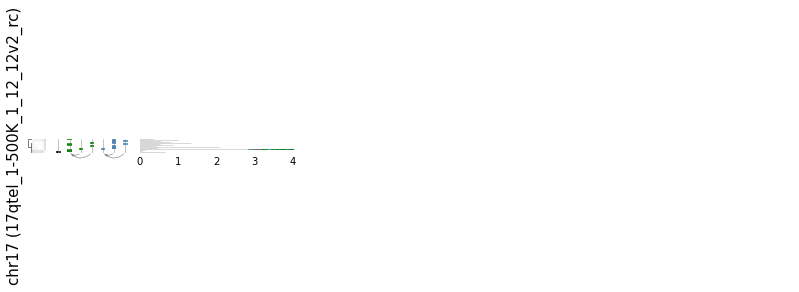

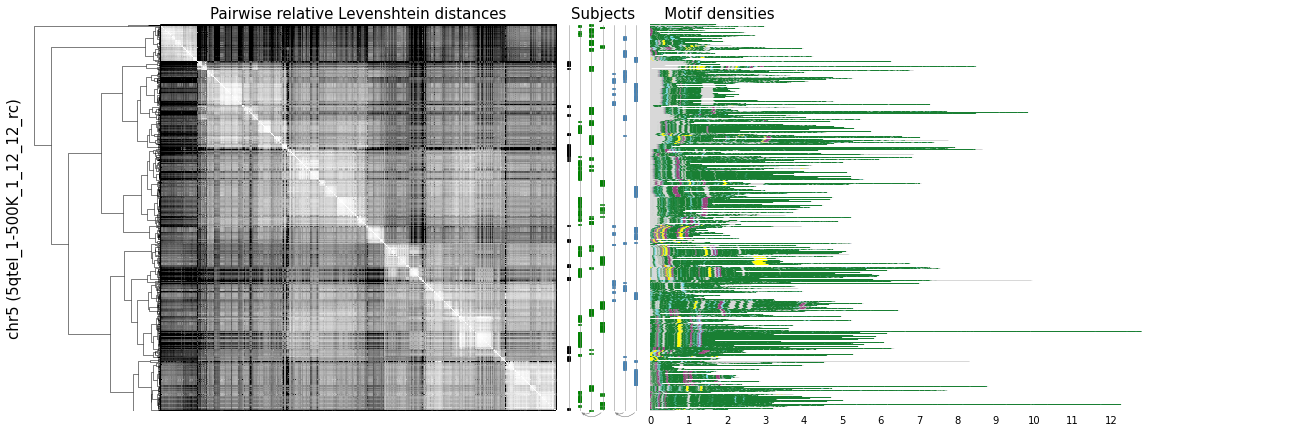

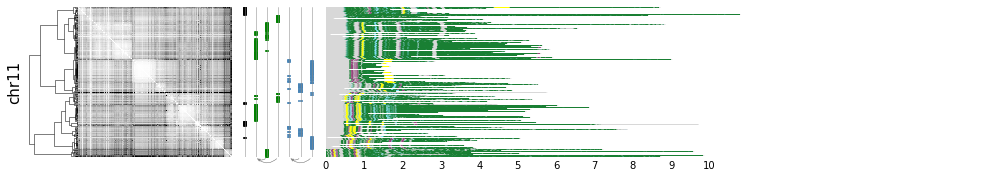

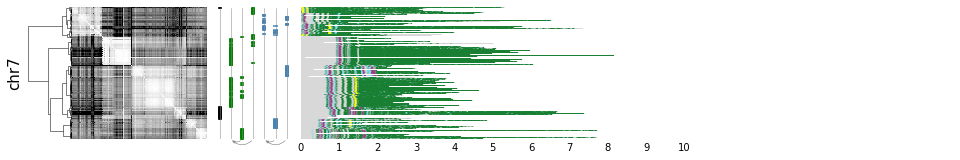

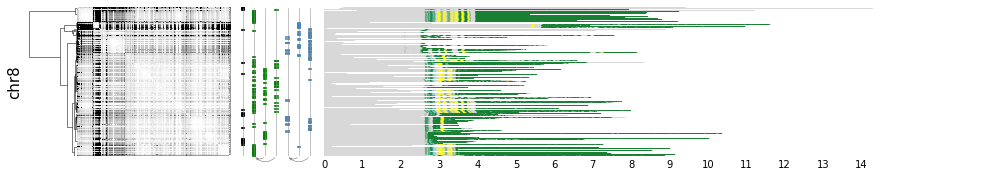

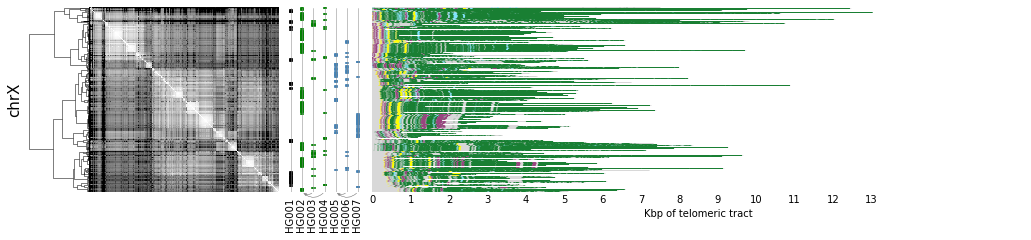

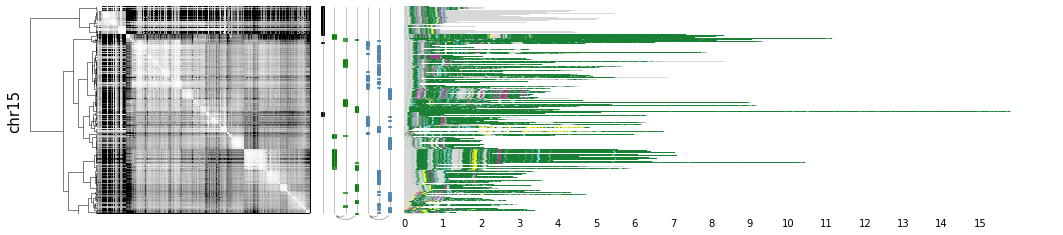

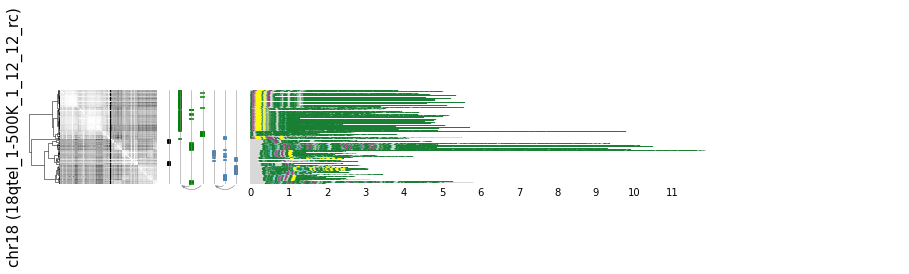

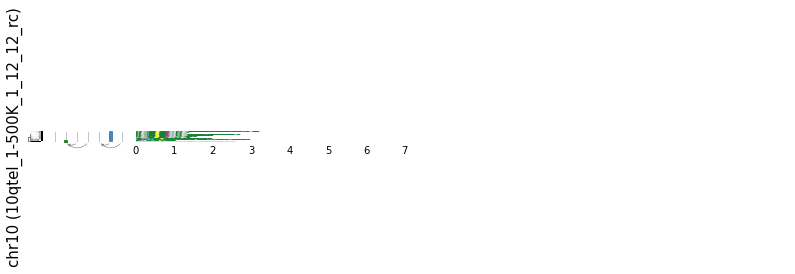

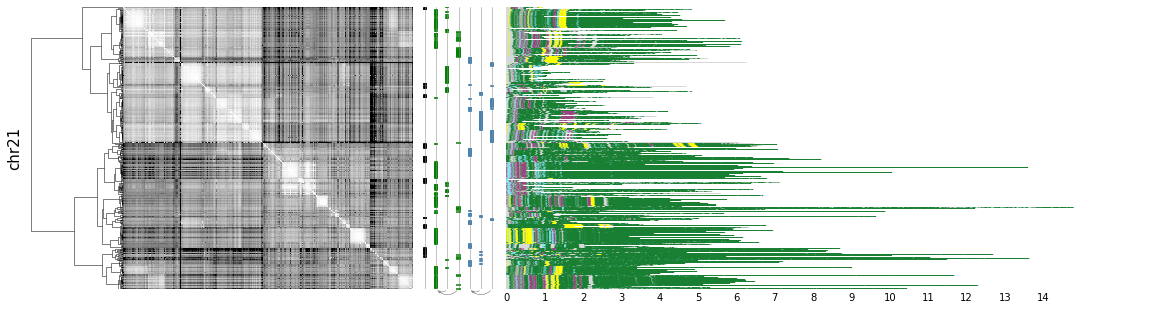

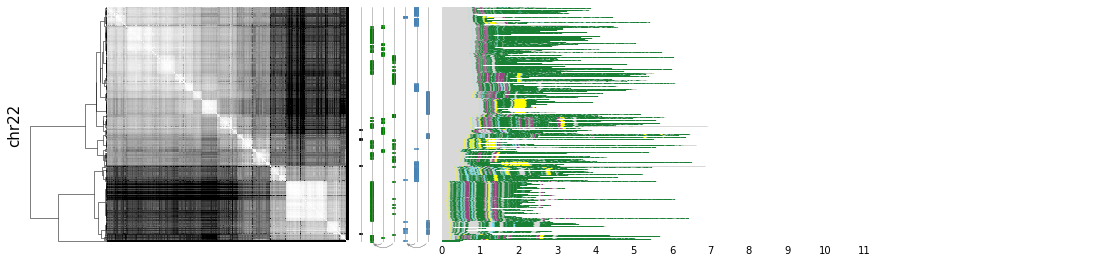

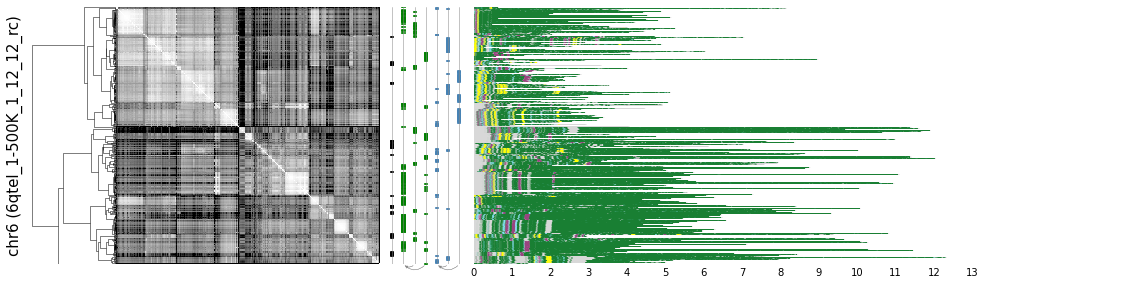

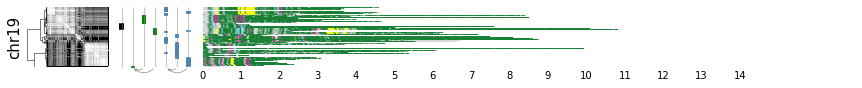

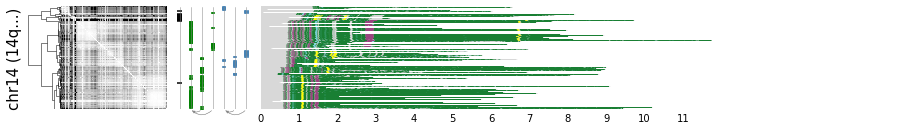

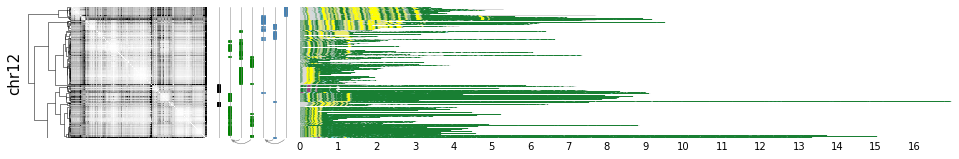

In [32]:
stats = pd.DataFrame(columns=[
    "NA12878", "AshkenazimTrio", "ChineseTrio",
    "cr", "cp",
    "s2t_p", "s2o_p", "t2o_p", "aff_p", "afm_p", "cff_p", "cfm_p",
])

cd_list, aff_list, afm_list, cff_list, cfm_list = [], [], [], [], []

for chrom in tqdm(RAW_GLOBAL_LDS):
    try:
        lds, Z, data2d, dispatcher, gf = process_lds(RAW_GLOBAL_LDS, chrom, DENSITIES, ecx)
    except ValueError: # too few observations
        continue
    try:
        cr, cp = cophenetic_correlation(lds, Z)
    except ValueError: # too few observations
        cr, cp = np.nan, np.nan
    fixup_labels(gf, chrom)
    gf.figure.savefig(
        "PacBio/haplotypes/clusters-q_arm/"+chrom+".pdf", bbox_inches="tight",
    )
    cd, aff, afm, cff, cfm, s2t_p, s2o_p, t2o_p, aff_p, afm_p, cff_p, cfm_p = process_distances(lds, dispatcher)
    cd_list.append(cd)
    aff_list.append(aff)
    afm_list.append(afm)
    cff_list.append(cff)
    cfm_list.append(cfm)
    stats.loc[chrom] = [
        np.nan, np.nan, np.nan,
        cr, cp,
        s2t_p, s2o_p, t2o_p, aff_p, afm_p, cff_p, cfm_p,
    ]
    for trio, subtree_count in count_subtrees(dispatcher).items():
        stats.loc[chrom, trio] = subtree_count

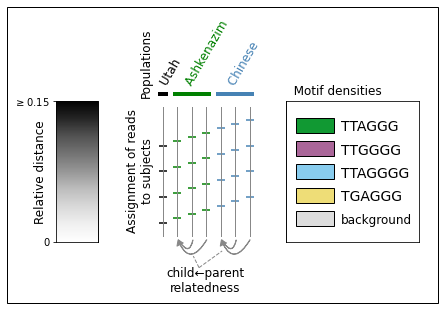

In [33]:
legend, axs = subplots(figsize=(6.5, 2.6), ncols=3, gridspec_kw=dict(width_ratios=(1, 4.5, 3.2), wspace=0))

axs[0].imshow(np.vstack([np.linspace(0, 1, 256)]).T, cmap="Greys_r", aspect="auto")
axs[0].set(xticks=[], yticks=[0, 255], yticklabels=["$\geq{}0.15$", "0"])
axs[0].text(x=0, y=128, s="Relative distance\n\n", rotation=90, ha="right", va="center", fontsize=12)

for x, subject in enumerate(sorted(SUBJECT_TO_TRIO)):
    axs[1].plot([x, x], [0, 1], color="#888", lw=1)
    axs[1].scatter([x]*4, np.linspace(.1, .7, 4)+x/30, color=POPULATION_COLORS[subject], marker="_", s=75)

axs[1].set(xlim=(-4.5, 8.5), xticks=[], yticks=[])
twiny = axs[1].twiny()
twiny.set(xlim=(-4.5, 8.5), xticks=[])
for tick in twiny.get_xticklabels():
    tick.set_rotation(80)
twiny.tick_params(axis="both", which="both", length=0)
for spine in "top", "bottom":
    axs[1].spines[spine].set_visible(False)
    twiny.spines[spine].set_visible(False)
axs[1].text(x=-1.6, y=.5, s="Assignment of reads\nto subjects", rotation=90, fontsize=12, ha="center", va="center")
axs[1].text(x=-1.15, y=1.075, s="Populations", rotation=90, ha="center", va="bottom", fontsize=12)

csty1 = "angle3,angleA=80,angleB=-60"
csty2 = "angle3,angleA=60,angleB=-70"
asty = "Simple, tail_width=.25, head_width=7, head_length=5"
draw_fancy_arrow(-0.02, 2.1, 1, axs[1], lw=1, csty=csty1)
draw_fancy_arrow(-0.02, 3.1, 1, axs[1], lw=1, asty=asty, csty=csty2)
draw_fancy_arrow(-0.02, 5.1, 4, axs[1], lw=1, csty=csty1)
draw_fancy_arrow(-0.02, 6.1, 4, axs[1], lw=1, asty=asty, csty=csty2)

axs[1].text(x=2.95, y=-.35, s="child{}parent\nrelatedness".format(chr(0x2190)), va="center", ha="center", fontsize=12)
line = Line2D((2.5, 4.1), (-.25, -.12), lw=1, ls="--", color="#888")
line.set_clip_on(False)
axs[1].add_line(line)
line = Line2D((2.5, 2.1), (-.25, -.16), lw=1, ls="--", color="#888")
line.set_clip_on(False)
axs[1].add_line(line)

line = Line2D((-.2, .2), (1.1, 1.1), lw=4, color=POPULATION_COLORS["HG001"])
line.set_clip_on(False)
axs[1].add_line(line)
axs[1].text(x=.4, y=1.1, s="  Utah", ha="center", va="bottom", rotation=60, fontsize=12, color=POPULATION_COLORS["HG001"])

line = Line2D((.8, 3.2), (1.1, 1.1), lw=4, color=POPULATION_COLORS["HG002"])
line.set_clip_on(False)
axs[1].add_line(line)
axs[1].text(x=2.9, y=1.1, s="  Ashkenazim", ha="center", va="bottom", rotation=60, fontsize=12, color=POPULATION_COLORS["HG002"])

line = Line2D((3.8, 6.2), (1.1, 1.1), lw=4, color=POPULATION_COLORS["HG005"])
line.set_clip_on(False)
axs[1].add_line(line)
axs[1].text(x=5.5, y=1.1, s="  Chinese", ha="center", va="bottom", rotation=60, fontsize=12, color=POPULATION_COLORS["HG005"])

axs[2].add_patch(Rectangle((0,4), 1.5, .65, facecolor="#119933", edgecolor="black"))
axs[2].text(x=1.75, y=4.25, s="TTAGGG", fontsize=14, va="center")
axs[2].add_patch(Rectangle((0,3), 1.5, .65, facecolor="#AA6699", edgecolor="black"))
axs[2].text(x=1.75, y=3.25, s="TTGGGG", fontsize=14, va="center")
axs[2].add_patch(Rectangle((0,2), 1.5, .65, facecolor="#88CCEE", edgecolor="black"))
axs[2].text(x=1.75, y=2.25, s="TTAGGGG", fontsize=14, va="center")
axs[2].add_patch(Rectangle((0,1), 1.5, .65, facecolor="#EEDD77", edgecolor="black"))
axs[2].text(x=1.75, y=1.25, s="TGAGGG", fontsize=14, va="center")
axs[2].add_patch(Rectangle((0,0), 1.5, .65, facecolor="#DDDDDD", edgecolor="black"))
axs[2].text(x=1.75, y=0.25, s="background", fontsize=12, va="center")
axs[2].set(xticks=[], yticks=[], xlim=(-.4, 4.8), ylim=(-.7, 5.4))
axs[2].set_title("  Motif densities", loc="left", fontsize=12)

legend.add_artist(Rectangle((.02, -.2), .92, 1.58, edgecolor="black", facecolor="none"))

legend.savefig("haplotypes-legend.pdf", bbox_inches="tight")

In [34]:
format_pval = lambda p: "ns" if (p >= .05) else ("<1.0e-300" if (p < 1e-300) else format(p, ".1e"))

In [35]:
st = stats.reindex(natsorted_chromosomes(stats.index)).copy()
st.index.name = "contig"
tc = st.iloc[:,:3].values.flatten()
tc = tc[~np.isnan(tc)]
print("Max subtree count on autosomes:", stats.iloc[:,:3].drop(index="chrX").max(axis=0).sort_values().iloc[[-1]].to_string())
print("Median subtree count:", np.median(tc))

Max subtree count on autosomes: AshkenazimTrio    19.0
Median subtree count: 5.0


In [36]:
st = stats.reindex(natsorted_chromosomes(stats.index)).copy()
st.index.name = "contig"
st = st.dropna().iloc[:,3:].reset_index()
st.insert(loc=0, column="chromosome", value=st["contig"].apply(convname))

coph = st.iloc[:,:4].copy()
coph["cp"] = multipletests(coph["cp"], method="bonferroni")[1]
coph["r"] = coph["cr"].apply(lambda r: format(r, ".2f"))
coph["p"] = coph["cp"].apply(format_pval)
coph.drop(columns=["cr", "cp"])

,chromosome,contig,r,p
0,chr5,5qtel_1-500K_1_12_12_rc,0.49,<1.0e-300
1,chr6,6qtel_1-500K_1_12_12_rc,0.37,<1.0e-300
2,chr7,chr7,0.68,<1.0e-300
3,chr8,chr8,0.27,<1.0e-300
4,chr11,chr11,0.44,<1.0e-300
5,chr12,chr12,0.40,<1.0e-300
6,chr14,14qtel_1-500K_1_12_12_rc,0.62,<1.0e-300
7,chr15,chr15,0.46,<1.0e-300
8,chr17,17qtel_1-500K_1_12_12v2_rc,0.98,4.2e-141
9,chr18,18qtel_1-500K_1_12_12_rc,0.52,<1.0e-300


In [37]:
st = stats.reindex(natsorted_chromosomes(stats.index)).copy()
st.index.name = "contig"
st = st.dropna().iloc[:,3:].reset_index()
st.insert(loc=0, column="chromosome", value=st["contig"].apply(convname))

rel = st.drop(columns=["contig", "cr", "cp"]).set_index("chromosome").copy()
rel.index = rel.index.map(lambda s: re.sub(r'^chr', "", s))

rel.loc["overall"] = [
    wilcoxon_dropna(pd.concat(cd_list), "subject", "trio")[1],
    wilcoxon_dropna(pd.concat(cd_list), "subject", "outgroup")[1],
    wilcoxon_dropna(pd.concat(cd_list), "trio", "outgroup")[1],
    wilcoxon_dropna(pd.concat(aff_list), "father to son", "father to mother")[1],
    wilcoxon_dropna(pd.concat(afm_list), "mother to son", "mother to father")[1],
    wilcoxon_dropna(pd.concat(cff_list), "father to son", "father to mother")[1],
    wilcoxon_dropna(pd.concat(cfm_list), "mother to son", "mother to father")[1],
]

rvf = rel.values.flatten()
bonferroni_lookup = dict(zip(rvf, multipletests(rvf, method="bonferroni")[1]))

rel = rel.applymap(lambda p: bonferroni_lookup[p]).T
rel.index.name, rel.columns.name = "comparison", None
rel.applymap(format_pval).iloc[:,:-1]

,5,6,7,8,11,12,14,15,17,18,19,21,22,X
comparison,,,,,,,,,,,,,,
s2t_p,2.5e-46,2.5e-27,1.7e-16,1.9e-01,2.8e-08,6.3e-04,ns,7.2e-28,ns,2.6e-07,4.6e-08,2.9e-34,1.5e-27,1.2e-14
s2o_p,5.5e-77,1.5e-51,3.4e-29,1.1e-02,2.4e-12,9.3e-16,ns,4.2e-35,ns,9.4e-16,3.4e-09,1.3e-56,9.2e-53,3.3e-20
t2o_p,4.4e-16,1.5e-32,2.8e-03,ns,ns,1.6e-12,1.1e-01,ns,ns,5.2e-07,1.7e-05,6.2e-18,1.2e-35,1.9e-01
aff_p,9.2e-10,2.5e-05,2.9e-04,4.6e-05,ns,1.8e-07,7.0e-03,ns,ns,3.1e-03,ns,7.0e-07,3.1e-05,2.1e-03
afm_p,5.4e-05,1.9e-04,1.9e-02,4.8e-03,ns,1.5e-03,1.8e-01,ns,ns,1.8e-01,ns,6.5e-06,2.1e-08,ns
cff_p,ns,ns,ns,ns,ns,1.0e-02,ns,4.0e-03,ns,ns,ns,ns,2.9e-04,3.6e-03
cfm_p,ns,4.8e-05,ns,ns,8.6e-06,ns,ns,ns,ns,ns,ns,ns,ns,1.3e-04


In [38]:
rel.iloc[:,[-1]].rename(columns={"overall": "adjusted p-value"}).applymap(format_pval)

,adjusted p-value
comparison,
s2t_p,7.7e-223
s2o_p,<1.0e-300
t2o_p,3.1e-120
aff_p,9.5e-33
afm_p,1.9e-26
cff_p,9.9e-02
cfm_p,ns
